In [1]:
import pandas as pd
from statistics import mean 
import re
from nltk.corpus import stopwords
stop = stopwords.words('russian')
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()
from nltk.tokenize import RegexpTokenizer
from textdistance import levenshtein

In [2]:
#texts and keywords:

file_names = ['left_activists', 'mipt_against_unification', 'my_international_romance', 'pornhub_research']
keyword_file = 'keywords.txt'
texts_dict = {}
for f in file_names:
    name = f+'.txt'
    with open(name, 'r', encoding='utf-8') as src:
        text = src.read()
        texts_dict[f] = text

In [3]:
#lemmatize texts:

tokenizer = RegexpTokenizer(r'\w+')

In [4]:
def preproc(text, stopwords, maximal=False):
    stopwords = set(stopwords)
    text = re.sub(r'\n', r' ', text)
    if maximal:
        text = re.sub(r'["%0-9A-Za-z]', r'', text)
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    newtext = ''
    for w in text:
        if w not in stopwords: 
            lemma = morph.parse(w)[0].normal_form + ' '
            newtext += lemma
    return newtext

In [5]:
preproc_texts_dict = {}
for t in texts_dict.keys():
    lemmatized = preproc(texts_dict[t], stop, maximal=False)
    preproc_texts_dict[t] = lemmatized

In [13]:
#lemmatize keywords:

keywords_dict = {}
keywords_lemmas_dict = {}
with open(keyword_file, 'r', encoding='utf-8') as src:
    kws = src.read()
    kws = kws.split('\n')
    for line in kws:
        text, keywords = (a for a in line.split(': '))
        keywords = keywords.split(', ')
        keywords_dict[text] = keywords
        kw_lemmas = []
        for kw in keywords:
            lemmas = preproc(kw, stopwords=stop)
            kw_lemmas.append(lemmas[:-1])
        keywords_lemmas_dict[text] = kw_lemmas

In [14]:
keywords_lemmas_dict

{'left_activists': ['коммунизм', 'партия n', 'красный'],
 'mipt_against_unification': ['кудрявцев', 'мфть', 'декан', 'подпись'],
 'my_international_romance': ['любовь',
  'отношение',
  'расстояние',
  'встречаться'],
 'pornhub_research': ['сексуальность',
  'дестигматизация',
  'порно',
  'порнография',
  'pornhub',
  'porn studies']}

In [15]:
keywords_dict

{'left_activists': ['коммунизм', 'партия N', 'красный'],
 'mipt_against_unification': ['Кудрявцев', 'МФТИ', 'декан', 'подписи'],
 'my_international_romance': ['любовь',
  'отношения',
  'расстояние',
  'встречаться'],
 'pornhub_research': ['сексуальность',
  'дестигматизация',
  'порно',
  'порнография',
  'pornhub',
  'porn studies']}

In [16]:
# searching for keywords in text 

def kw_brute_search(keywords, corpus):
    for name in keywords.keys():
        print(f'Sorted keyword occurences for {name.upper()}:')
        text = corpus[name]
        kws = keywords[name]
        kw_list = []
        for kw in kws:
            kw_occs = text.count(kw)
            #print(f'{kw} - {kw_occs}')
            kw_list.append([kw, kw_occs])
        kw_df = pd.DataFrame(kw_list, columns=['keyword', 'count'])
        kw_df = kw_df.sort_values(by=['count'], ascending=False)
        print(kw_df)
        print('-----------------')
    return 'done'

In [17]:
kw_brute_search(keywords_dict, texts_dict) #non-lemmatized texts

Sorted keyword occurences for LEFT_ACTIVISTS:
     keyword  count
2    красный      3
0  коммунизм      2
1   партия N      0
-----------------
Sorted keyword occurences for MIPT_AGAINST_UNIFICATION:
     keyword  count
1       МФТИ      8
0  Кудрявцев      4
2      декан      4
3    подписи      0
-----------------
Sorted keyword occurences for MY_INTERNATIONAL_ROMANCE:
       keyword  count
1    отношения     13
2   расстояние      2
0       любовь      0
3  встречаться      0
-----------------
Sorted keyword occurences for PORNHUB_RESEARCH:
           keyword  count
2            порно     21
0    сексуальность      3
1  дестигматизация      3
5     porn studies      3
3      порнография      0
4          pornhub      0
-----------------


'done'

In [18]:
kw_brute_search(keywords_lemmas_dict, preproc_texts_dict) #lemmatized texts

Sorted keyword occurences for LEFT_ACTIVISTS:
     keyword  count
1   партия n      9
2    красный      6
0  коммунизм      2
-----------------
Sorted keyword occurences for MIPT_AGAINST_UNIFICATION:
     keyword  count
1       мфть      8
0  кудрявцев      4
2      декан      4
3    подпись      2
-----------------
Sorted keyword occurences for MY_INTERNATIONAL_ROMANCE:
       keyword  count
1    отношение     16
2   расстояние      9
3  встречаться      2
0       любовь      0
-----------------
Sorted keyword occurences for PORNHUB_RESEARCH:
           keyword  count
2            порно     23
4          pornhub     12
3      порнография     11
0    сексуальность      8
1  дестигматизация      7
5     porn studies      4
-----------------


'done'

=> При поиске по подстрокам предсказуемо нашлось мало ключевых слов в нелемматизированных текстах, и неплохие результаты в лемматизированных

## RAKE

In [27]:
!pip install python-rake

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [19]:
import RAKE

In [20]:
rake = RAKE.Rake(stop)

In [21]:
# non-lemmatized texts:
kw_pred_dict = {}

def extraction(m_w, m_f):
    for text in texts_dict.keys():
        #print(text+':')
        rake_kw_list = rake.run(texts_dict[text], maxWords=m_w, minFrequency=m_f)
        kw_list = []
        for kw in rake_kw_list[:15]:
            #print(kw)
            kw_list.append(kw[0])
        kw_pred_dict[text] = kw_list
    return kw_pred_dict

for text in texts_dict.keys():
    print(text+':')
    rake_kw_list = rake.run(texts_dict[text], maxWords=3, minFrequency=2)
    kw_list = []
    for kw in rake_kw_list[:15]:
        print(kw)
        kw_list.append(kw[0])
    kw_pred_dict[text] = kw_list
    print('-----------')

left_activists:
('революцию', 1.0)
('некоторые', 1.0)
('времени', 1.0)
('митингах', 1.0)
('те', 1.0)
('новички', 1.0)
('«капитала»', 1.0)
('сети', 1.0)
('текст', 1.0)
('»', 0)
-----------
mipt_against_unification:
('словам', 2.0)
('это', 1.75)
('комментарием', 1.0)
('вряд', 1.0)
('«', 0)
-----------
my_international_romance:
('это время', 4.233333333333333)
('самом деле', 4.0)
('это', 1.9)
('отношения', 1.875)
('н', 1.8333333333333333)
('тяжело', 1.3333333333333333)
('говорил', 1.25)
('постоянно', 1.0)
('думала', 1.0)
('сначала', 1.0)
('норвегию', 1.0)
('смогу', 1.0)
('согласилась', 1.0)
('поэтому', 1.0)
('кажется', 1.0)
-----------
pornhub_research:
('екатерина понамарева', 4.0)
('«порнификация»', 2.0)
('сексуальности', 2.0)
('это', 1.8)
('pornhub', 1.6666666666666667)
('традиций', 1.3333333333333333)
('сексе', 1.0)
('человек', 1.0)
-----------


In [22]:
from textdistance import jaccard
jaccard('abc', 'def')

0.0

In [23]:
def evaluation(y, pred, threshold=0.7):
    
    tp, fp, fn = 0, 0, 0
    
    kw_y_used = set()
    for kw_pred in pred:
        likelihood_list = sorted([(levenshtein.normalized_similarity(kw_pred, y[i]), y[i]) for i in range(len(y))])
        likeliest_score, likeliest = likelihood_list[-1]

        if likeliest_score > threshold:
            tp += 1
            kw_y_used.add(likeliest)
        else:
            fp += 1
    for y_kw in y:
        if y_kw not in kw_y_used:
            fn += 1
    
    accuracy = tp / (tp + fn + fp + 1)
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = (2 * precision * recall) / (precision + recall + 1)

    return precision, accuracy, f1 

In [24]:
def mean_metrics(y, pred, threshold=0.7):
    aver_prec, aver_acc, aver_f1 = [], [], []
    for text_name in y.keys():
        precision, accuracy, f1 = evaluation(y[text_name], pred[text_name], threshold=threshold)
        aver_prec.append(precision)
        aver_acc.append(accuracy)
        aver_f1.append(f1)
    aver_prec = mean(aver_prec)
    aver_acc = mean(aver_acc)
    aver_f1 = mean(aver_f1)
    return aver_prec, aver_acc, aver_f1

In [25]:
import matplotlib.pyplot as plt

thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(kw_pred_dict, keywords_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Clipping level')
plt.ylabel('Metrics value ')
plt.title('RAKE, non-lemmatized texts')


Text(0.5,1,'RAKE, non-lemmatized texts')

In [26]:
threshold = 0.3
word_range = [1, 2, 3, 4, 5]
word_count = [1, 2, 3, 4, 5, 7, 10]

for count in word_count:
    print(f'Param minFrequency = {count}:')
    for w_range in word_range:
        print(f'\tParam maxWords = {w_range}:')
        kw_pred_dict = extraction(w_range, count)
        try:
            prec, acc, f1 = mean_metrics(kw_pred_dict, keywords_dict, threshold=threshold)
        except: prec, acc, f1 = 0, 0, 0
        print(f'\t\tPrecision = {prec}')
        print(f'\t\tAccuracy = {acc}')
        print(f'\t\tF1-score = {f1}')


Param minFrequency = 1:
	Param maxWords = 1:
		Precision = 0.46785714285714286
		Accuracy = 0.13759889920880633
		F1-score = 0.08922695680225226
	Param maxWords = 2:
		Precision = 0.3107142857142857
		Accuracy = 0.08543417366946779
		F1-score = 0.0544030044030044
	Param maxWords = 3:
		Precision = 0.16964285714285715
		Accuracy = 0.0533625730994152
		F1-score = 0.03081425940541962
	Param maxWords = 4:
		Precision = 0.1
		Accuracy = 0.027777777777777776
		F1-score = 0.01639344262295082
	Param maxWords = 5:
		Precision = 0.0
		Accuracy = 0.0
		F1-score = 0.0
Param minFrequency = 2:
	Param maxWords = 1:
		Precision = 0.39107142857142857
		Accuracy = 0.18834841628959276
		F1-score = 0.12735569515230533
	Param maxWords = 2:
		Precision = 0.39107142857142857
		Accuracy = 0.1769847799259564
		F1-score = 0.12058826903004048
	Param maxWords = 3:
		Precision = 0.39107142857142857
		Accuracy = 0.1769847799259564
		F1-score = 0.12058826903004048
	Param maxWords = 4:
		Precision = 0.341071428571428

=> лучшее качество: при параметре maxWords = 1 и minFrequency = 1 

In [27]:
#lemmatizwd texts
def preproc_rake(text, maximal=False):
    text = re.sub(r'\n', r' ', text)
    if maximal:
        text = re.sub(r'["%0-9A-Za-z]', r'', text)
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    newtext = ''
    for w in text:
        lemma = morph.parse(w)[0].normal_form + ' '
        newtext += lemma
    return newtext

In [28]:
rake_preproc_texts_dict = {}
for t in texts_dict.keys():
    lemmatized = preproc_rake(texts_dict[t], maximal=False)
    rake_preproc_texts_dict[t] = lemmatized

In [29]:
kw_pred_dict = {}

for text in texts_dict.keys():
    print(text+':')
    rake_kw_list = rake.run(rake_preproc_texts_dict[text], maxWords=3, minFrequency=1)
    kw_list = []
    for kw in rake_kw_list[:15]:
        print(kw)
        kw_list.append(kw[0])
    kw_pred_dict[text] = kw_list
    print('______________')

left_activists:
('ближний бизнес центр', 9.0)
('занимать маленькая аудитория', 9.0)
('иметь ячейка практически', 9.0)
('основное гуманитарный вуз', 9.0)
('колготки напоминать неформал', 9.0)
('аспект философия марксизм', 9.0)
('цель нужно вложить', 9.0)
('голов молодая партиец', 9.0)
('денежный проблема родитель', 9.0)
('несогласный власть рабочий', 9.0)
('владеть отлично нисколько', 9.0)
('цитирование теоретик практически', 9.0)
('прийтись временно удалить', 9.0)
('указание авторство поэтому', 9.0)
('завод предвыборный агитация', 8.8)
______________
mipt_against_unification:
('мфть написать аргумент', 9.0)
('вызвать профессор отметить', 9.0)
('хотеть продолжать работа', 9.0)
('получить ответ однако', 9.0)
('видеть большой возможность', 9.0)
('анонсировать новый встреча', 9.0)
('энергетика фпфэ объединить', 8.666666666666666)
('помочь разрешить ситуация', 8.5)
('проректор артем воронов', 8.5)
('факультет проблема физика', 8.4)
('факультет пока непонятно', 8.4)
('пост директор лфи', 8.4

Text(0.5,1,'RAKE, lemmatized texts')

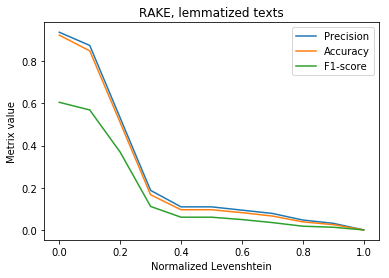

In [35]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_lemmas_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Normalized Levenshtein')
plt.ylabel('Metrix value')
plt.title('RAKE, lemmatized texts')


## TextRank

In [33]:
from gensim.summarization import keywords as kw

In [34]:
#non-lemmatized
from gensim.summarization import keywords as kw

kw_pred_dict = {}

for text in texts_dict.keys():
    print(text+':')
    text_rank = kw(texts_dict[text], pos_filter=[], scores=True)
    kw_list = []
    for k_w in text_rank[:15]:
        print(f'{k_w[0]}\t{k_w[1]}')
        kw_list.append(k_w[0])
    print('_________________\n\n')
    kw_pred_dict[text] = kw_list

left_activists:
что	0.22172286312417855
коммунистическои партии	0.13497276915346926
можно	0.1120533262689197
агитация	0.10464093362067968
это	0.10089017208169469
они занимают	0.09454246319462281
которых	0.09226530147905807
левых	0.09085405319803344
людеи	0.08786315244874589
молодых	0.0856750835702003
нужно	0.08557664482713492
если	0.08222136166193328
однако	0.07788633886205437
очень	0.07782673487335405
все	0.0775001748250827
_________________


mipt_against_unification:
фпфэ	0.21499631654357418
мфти	0.20775127724880071
студенты	0.18894372673242682
студентов	0.18324676163491777
киселева	0.18207155645868967
лфи	0.1551965758981849
октября ректор	0.14609980970849007
время были	0.11537401326334296
факультета	0.11528053527073925
фопф	0.11510206360157095
физтех	0.1068795194392063
обращал	0.10408061953401253
факультетов	0.10316278902573581
приказ	0.10276824343997337
для	0.10259820240686197
_________________


my_international_romance:
мне	0.2704770671406772
что поддерживать	0.24740489059309112

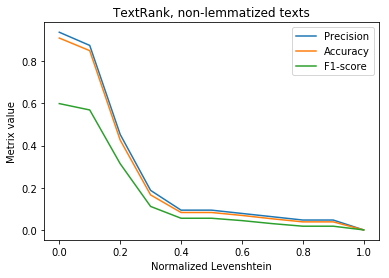

In [36]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Normalized Levenshtein')
plt.ylabel('Metrix value')
plt.title('TextRank, non-lemmatized texts')
plt.show()

In [37]:
#lemmatized texts
kw_pred_dict = {}

for text in texts_dict.keys():
    print(text+':')
    text_rank = kw(preproc_texts_dict[text], pos_filter=[], scores=True)
    kw_list = []
    for k_w in text_rank[:15]:
        print(f'{k_w[0]}\t{k_w[1]}')
        kw_list.append(k_w[0])
    kw_pred_dict[text] = kw_list
    print('_________________\n\n')

left_activists:
которыи	0.2737128087060504
коммунистическии партия	0.16425327735770376
агитация	0.1180498678953448
другои	0.11730345883139186
молодежь это	0.10714862903785846
красныи флаг	0.1054119069546339
власть	0.10480127717314687
марксистскии кружка	0.10041545857182002
революция	0.10005546741198267
свои	0.09978125735303524
буржуи член	0.09673545155539304
движение	0.09618600963650246
весь	0.09518726161406621
левыи	0.09307128762598878
один	0.09197949178031814
_________________


mipt_against_unification:
студент мфть	0.2285499095416179
фпфэ	0.1888421646943553
школа	0.18489657585858
декан факультет	0.18117785974702352
октябрь ректор	0.16735492002956848
валерии киселев это	0.16389473292522924
которыи	0.13710874609909418
решение	0.12890493353268948
лфи	0.12625486684263784
фопф	0.12113914888487153
представитель	0.11619726878020212
время	0.11482718631676733
ситуация	0.11194406032205534
воронов	0.10706895714568193
вуз	0.10565585212931966
_________________


my_international_romance:
это	0.

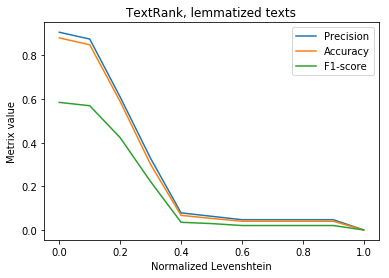

In [38]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_lemmas_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Normalized Levenshtein')
plt.ylabel('Metrix value')
plt.title('TextRank, lemmatized texts')
plt.show()

#### Выводы

* Лемматизация немного повышает качество выдачи в алгоритме RAKE, но в остальном она не сильно влияет на качество;

* у TextRank качество результатов лучше, чем у RAKE; 

* метрики в том виде, в котором они есть, показывают плохой результат. Но это в большей степени проблема метрик, а не алгоритмов - поиск по нормированному расстоянию Левенштейна не позволяет уловить важные сходства и различия между найденными и реальными ключевыми словами. 

* Может быть нужно дополнительно делить каждое ключевое слово по пробелу и искать его в разделённых по пробелам реальных словах - но тогда неясно, были ли выловлены необходимые кластеры целиком. В общем, по-настоящему показательные метрики предстоит ещё придумать